In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), ".."))
main_dir = os.path.abspath('..')
os.chdir(main_dir)
sys.path.append(main_dir)

import numpy as np
import copy
from sklearn.model_selection import train_test_split
from PhysicsRegression import PhyReg

### Step1: Load SSN data

We keep the data from year 1976 to 2019 (cycle 21 to 24) as testing data, and use the others as training data. We also select different amount of data for training to derive a consist conclusion.

In [2]:
x_to_fit = []
y_to_fit = []

np.random.seed(2024)

with open("./data/physics_data/SN_m_tot_V2.0.txt", "r") as fi:
    context = fi.read().split("\n")
context = [c.split() for c in context][:-1]
times = np.array([float(c[2]) for c in context])
nums = np.array([float(c[3]) for c in context])

c_times = times[1280: 2730]
c_nums =  nums [1280: 2730]
min_times1 = np.min(c_times)
max_times1 = np.max(c_times)
c_times = (c_times - min_times1) / (max_times1 - min_times1) * 8
x_to_fit.append(c_times.reshape((-1, 1)))
y_to_fit.append(c_nums.reshape((-1, 1)))

x_train, x_test, y_train, y_test = train_test_split(x_to_fit[0], y_to_fit[0], test_size=0.15, random_state=2024)
x_to_fit[0] = x_train
y_to_fit[0] = y_train

### Step2: Inference with PhyReg

We begin with the first dataset, i.e. from year 1855 to 1976.

In [3]:
phyreg = PhyReg(
    path = "./model.pt",
    max_len=1000,
    refinement_strategy = 'id'
)

phyreg.fit(
    x_to_fit[:1], y_to_fit[:1], 
    use_Divide=False, 
    use_MCTS=False, 
    use_GP=False, 
    use_pysr_init=True, 
    use_const_optimization=False,
    verbose=True,
    oracle_name="physical1",
    oracle_file="./physical/data/oracle_model_case1/",
    oracle_bs=36, oracle_lr=0.002, oracle_epoch=1000,
    use_seperate_type=["id"]
)

Generating formula through End-to-End...
Finished forward in 17.56332230567932 secs
Removed 2/4 skeleton duplicata
idx : 0
expr: (31.475087226597463 * (pi * ((sin((-1.9302722098522511 * x_0)))**2 * 1/(((sin((-1.015687509025571 * x_0)))**2 + (cos((-1.1768793219379192 * x_0)))**2)))))
mse : 5927.87206591267



Let's incorporate a few free coefficients to help optimize the constants.

In [ ]:
np.random.seed(2024)

best_gens = phyreg.best_gens
# this formula is totally the same as the result of PhyE2E
best_gens[0]["predicted_tree"] = "(98.8819 * (((sin((1.9302722098522511 * x_0 + 0.0)))**2 * 1/((1.0 * (sin((1.015687509025571 * x_0 + 0.0)))**2 + (1.0 * cos((1.1768793219379192 * x_0 + 0.0)))**2 + 1.0)))))"
phyreg.params.num_bfgs = 100
best_gens = phyreg.constant_optimization(best_gens, x_to_fit, y_to_fit)
phyreg.express_best_gens(best_gens, use_sp=True)
phyreg.express_skeleton(best_gens, use_sp=True)

idx : 0
expr: 106.047097970284*sin(4.361890470959715*x_0 - 0.09036952709731985)**2/(0.637539089482743*sin(0.48341717348326757*x_0 + 3.1531080470589243)**2 + 0.11799792365845*cos(1.2002815988318507*x_0 - 0.18912167068966976)**2 + 0.420323595036895)
mse : 1743.759765925517

idx          : 0
expr skeleton: C_0*sin(C_1*x_0 - C_2)**2/(C_3*sin(C_4*x_0 + C_5)**2 + C_6*cos(C_7*x_0 - C_8)**2 + C_9)
constants    : 106.047 4.362 0.09 0.638 0.483 3.153 0.118 1.2 0.189 0.42



### Step3: plot the predicted formula

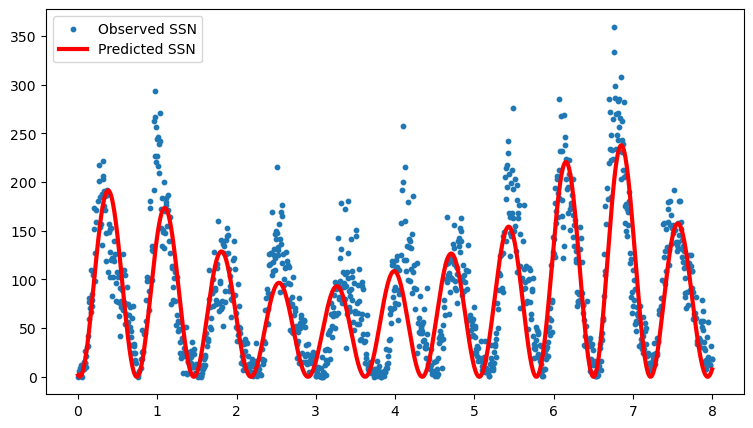

In [9]:
import matplotlib.pyplot as plt
from numpy import sin, cos, pi

x_0 = c_times
func = eval(best_gens[0]["predicted_tree"])
plt.figure(figsize=(9, 5))
plt.scatter(x_to_fit[0], y_to_fit[0], label="Observed SSN", s=10)
plt.plot(x_0, func, label="Predicted SSN", color="red", linewidth=3)
plt.legend()
plt.show()